# HA-LAT-001
## Latencia en evaluación de correctitud de una respuesta enviada en examen teórico

### Experimento


#### importación de librerias e inicialización de variables

El uso de las librerías es el siguiente: 

**grequests**: gestión de peticiones concurrentes  
**requests**: peticiones sincrónas  
**matplotlib**: librería gráfica  
**numpy**: generación de arrays  
**random**: aleatoriedad  

In [1]:
%matplotlib widget
import grequests
import requests
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
import numpy as np
import random 


#### inicialización de variables

***path_url***: endpoint del servicio  
***questions_cant***: número de preguntas para crear en la base de datos  
***answers_cant***: número de respuestas a crear por cada pregunta creada  
***num_iterations***: número de iteraciones a ejecutar  
***num_async_calls***: número de llamadas asíncronas. Se incrementa en cada iteración  

In [2]:

#path_url = "http://localhost:8000"
path_url = "http://lb-abcjobs-exp-1-v2-1155292492.us-east-1.elb.amazonaws.com"
questions_cant = 2
answers_cant = 4 
num_iterations = 5
num_async_calls = 0

#### Base de datos

**populate_quizes()**: borra todo el contenido de preguntas y respuestas, y genera nuevo contenido de acuerdo a la configuración  
**/truncquizes**: borra contenido  
**/populatequizes/{questions_cant}/{answers_cant}**: crea `questions_cant` preguntas con `answers_cant` respuestas cada una  

In [3]:
def populate_quizes():
  requests.get(f"{path_url}/truncquizes")
  requests.get(f"{path_url}/populatequizes/{questions_cant}/{answers_cant}")
  return True 

populate_quizes()  

True

#### consumo de servicio de validación de respuesta

**/checkanswer/{question_id}/{answer_id}**: este servicio evalua la correctitud de la respuesta `{answer_id}` a la pregunta `{question_id}`. Su response es de la forma:  

`response: <Response [200]>, data: {'ok': True, 'status': 'Wrong', 'message': 'Wrong answer', 'latency_ms': 4, 'cpu_perc': 0.61, 'mem_perc': 23.2}`  
`response: <Response [200]>, data: {'ok': True, 'status': 'Right', 'message': 'Right answer', 'latency_ms': 3, 'cpu_perc': 0.61, 'mem_perc': 23.2}`  

donde se obtiene si la respuesta es correcta o incorrecta `status`, el tiempo `latency_ms` que tardó en validar la correctitud de la respuesta, el porcentaje `cpu_perc` de uso de la cpu y el porcentaje `mem_perc` de memoria de la máquina (*contenedor) donde se ejecuta el servicio 

**call_service(iteration)**: llamado concurrente del servicio de validación de respuesta `/checkanswer`  
- a partir de la iteración `iteration` calcula el número de llamadas concurrentes `num_async_calls` a ejecutar  
- genera una lista dinámica de urls con preguntas y respuestas aleatorias  
- a través de `grequests.get(link)` se realiza el llamado concurrente de las urls generadas  
- a través de `grequests.map(our_requests)` se obtiene los responses de cada petición  

*El algoritmo de incremento de peticiones concurrentes genera el siguiente resultado:*  
- peticiones concurrentes: incrementa el número de peticiones concurrentes sumando el número de iteración actual
- peticiones acumuladas: es la suma de todas las peticiones concurrentes realizadas

| iteración | # peticiones concurrentes | # peticiones acumuladas      |
|       --: |                       --: |                          --: |
|         1 |                         1 |                            1 | 
|         2 |                         3 |                            4 | 
|         3 |                         6 |                           10 | 
|         4 |                        10 |                           20 | 
|         5 |                        15 |                           35 | 
|         n |            sum(iteracion) | sum(peticiones concurrentes) | 

In [4]:
def call_service(iteration):
  global num_async_calls
  num_async_calls = num_async_calls + iteration
  """ print(f"num_async_calls: {num_async_calls}") """
  urls = []  
  #print(f"inicia petición: {num_async_calls}")  
  for q in range(num_async_calls):
    question_id = random.randint(1,questions_cant)
    max_answer_id = (answers_cant * question_id)
    min_answer_id = max_answer_id - answers_cant + 1
    answer_id = random.randint(min_answer_id,max_answer_id)
    urls.append(f"{path_url}/checkanswer/{question_id}/{answer_id}")  
  our_requests = (grequests.get(link) for link in urls)
  responses = grequests.map(our_requests)  
  #print(f"num_async_calls: {num_async_calls}")    
  #print(f"finaliza petición: {num_async_calls}")
  #num_async_calls = num_async_calls * 2  
  return responses

call_service(1)

[<Response [200]>]

#### Gráfica

##### Flujo de operación:  

`fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, constrained_layout = True, figsize=(10,7))`:   
**subplots**: genera 4 filas y 1 columna  
**fig**: retorna el objeto figura para graficar  
**ax0, ax1, ax2, ax3**: son las 4 gráficas para concurrencia, latencia, cpu y memoria respectivamente  

`animation.FuncAnimation(fig, update_plot, data_gen, interval=500, repeat=False, cache_frame_data=False)`:  
**animation.FuncAnimation**: realiza la animación que permite ver como se grafican los resultados a medida que se realizan las peticiones  
**data_gen**: es la función que genera periódicamente los datos a graficar
**update_plot**: es la función que refresca la gráfica para cada iteración  
**interval**: es el intervalo de tiempo en milisegundos entre cada iteración  

`data_gen()`: para cada iteración realiza el llamado del servicio de evaluación de respuesta indicando la iteración correspondiente, obtiene todos los responses y asigna los valores recibidos de latencia, cpu y memoria a los arrays de datos

`update_plot(n)`: a partir del número actual de peticiones concurrentes `n` actualiza cada línea `line[x]` gráfica para los `n` valores actuales


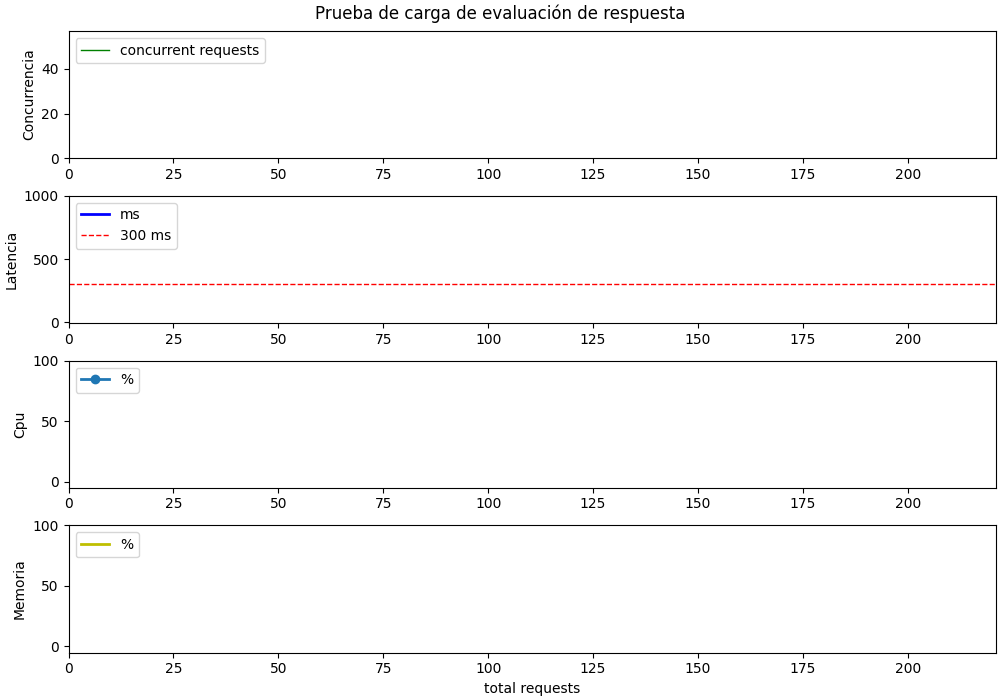

response: <Response [200]>, data: {'ok': True, 'status': 'Right', 'message': 'Right answer', 'latency_ms': 2, 'cpu_perc': 0.8, 'cpu_avg': 0.1220703125, 'mem_perc': 22.9}
response: <Response [200]>, data: {'ok': True, 'status': 'Right', 'message': 'Right answer', 'latency_ms': 2, 'cpu_perc': 1.2, 'cpu_avg': 0.1220703125, 'mem_perc': 22.9}
response: <Response [200]>, data: {'ok': True, 'status': 'Right', 'message': 'Right answer', 'latency_ms': 3, 'cpu_perc': 1.8, 'cpu_avg': 0.1220703125, 'mem_perc': 22.9}
response: <Response [200]>, data: {'ok': True, 'status': 'Right', 'message': 'Right answer', 'latency_ms': 2, 'cpu_perc': 66.7, 'cpu_avg': 0.1220703125, 'mem_perc': 22.9}
response: <Response [200]>, data: {'ok': True, 'status': 'Right', 'message': 'Right answer', 'latency_ms': 4, 'cpu_perc': 0.0, 'cpu_avg': 0.1220703125, 'mem_perc': 22.9}
response: <Response [200]>, data: {'ok': True, 'status': 'Wrong', 'message': 'Wrong answer', 'latency_ms': 2, 'cpu_perc': 0.0, 'cpu_avg': 0.122070312

In [5]:
concurrence_array = []
latency_array = []
cpu_array = []
memory_array = []

#num_x_data = pow(2, (num_iterations))
ylim = sum(range(num_iterations+1)) + 2
num_requests = sum([sum(range(x+1)) for x in range(num_iterations+1)])
#num_x_data = sum(range(num_iterations+1))
xlim = num_requests + 1
#print(f"xlim: {xlim}")

X = np.linspace(0, xlim, num_requests).astype(int)

def update_plot(n):
  #print(f"entra a update_plot: {n}")
  n = n - 1
  concurrence = np.array(concurrence_array).astype(int)
  latency = np.array(latency_array).astype(int)
  cpu = np.array(cpu_array).astype(int)
  memory = np.array(memory_array).astype(int)
  """ print(f"\nn: {n}")
  print(f"x: {len(X)}")
  print(f"concurrence: {len(concurrence)}")
  print(f"latency: {len(latency)}")
  print(f"cpu: {len(cpu)}")
  print(f"memory: {len(memory)}")
  print(f"X: {X}")
  print(f"concurrence: {concurrence}")
  print(f"latency: {latency}")  
  print(f"cpu: {cpu}")
  print(f"memory: {memory}") """
  m = min(len(X), len(concurrence), len(latency), len(cpu), len(memory))
  """ print(f"m: {m}") """
  line[0].set_data(X[:m], concurrence[:m])
  line[1].set_data(X[:m], latency[:m])
  line[2].set_data(X[:m], cpu[:m])
  line[3].set_data(X[:m], memory[:m])
  return line

def data_gen():
  global num_async_calls, concurrence_array, latency_array, cpu_array, memory_array
  num_async_calls = 0
  concurrence_array.clear()
  latency_array.clear()
  cpu_array.clear()
  memory_array.clear()
  #print("ingresa a data_gen")
  for iteration in range(num_iterations):
    #print(f"iteración gen_data: {i}")
    responses = call_service(iteration+1)
    """ print(f"responses: {responses}") """
    """ print(f"count responses: {len(responses)} for iteration: {iteration+1}") """
    for response in responses:
      if response :
        data = response.json()
        concurrence_array.append(num_async_calls)
        latency_array.append(data["latency_ms"])
        cpu_array.append(data["cpu_perc"])
        memory_array.append(data["mem_perc"])
        print(f"response: {response}, data: {data}")
    yield num_async_calls
 
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, constrained_layout = True, figsize=(10,7))
#fig.tight_layout()
fig.suptitle('Prueba de carga de evaluación de respuesta')

lines0, = ax0.plot([], [], 'g-', lw=1, label="concurrent requests")
ax0.set_ylabel('Concurrencia')
ax0.set_ylim(0, ylim)
ax0.set_xlim(0, xlim)
ax0.legend(loc='upper left')

lines1, = ax1.plot([], [], 'b-', lw=2, label="ms")
ax1.set_ylabel('Latencia')
ax1.set_ylim(-5, 1000)
ax1.set_xlim(0, xlim)
ax1.axhline(y=300, color="r", label="300 ms", linewidth=1, linestyle='--')
ax1.legend(loc='upper left')

lines2, = ax2.plot([], [], 'o-', lw=2, label="%")
ax2.set_ylabel('Cpu')
ax2.set_ylim(-5, 100)
ax2.set_xlim(0, xlim)
ax2.legend(loc='upper left')

lines3, = ax3.plot([], [], 'y-', lw=2, label="%")
ax3.set_xlabel('total requests')
ax3.set_ylabel('Memoria')
ax3.set_ylim(-5, 100)
ax3.set_xlim(0, xlim)
ax3.legend(loc='upper left')

line = [lines0, lines1, lines2, lines3]

#ani = animation.FuncAnimation(fig, update_plot, frames=8, repeat=False )
ani = animation.FuncAnimation(fig, update_plot, data_gen, interval=500, repeat=False, cache_frame_data=False)
#ani = animation.FuncAnimation(fig, update_plot, np.linspace(0, 3, 3), interval=500, repeat=False, cache_frame_data=False)
plt.show()
#plt.close()